# HW6 - Image Captioning, Generative Vision

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import io
import requests

import tensorflow as tf

import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Input, Dense, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Lambda, AveragePooling2D
from tensorflow.keras.layers import LSTM, CuDNNLSTM, CuDNNGRU, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import mse
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tqdm import tqdm

## Image Captioning

Image captioning is the foremost application of the connection between language and vision. We will implement a method close to "Show and Tell": https://arxiv.org/abs/1411.4555 [Vinyals '14]

To perform image captioning we will use the Flickr30k dataset, which has 5 caption sentences for each image.

First we download the captions and preprocess them.

In [2]:
if not os.path.isfile('flickr30k_captions.csv'):
    dl_url = 'https://storage.googleapis.com/cse527-spring19/flickr30k_captions.csv'
    with open('flickr30k_captions.csv', 'wb') as f:
        f.write(requests.get(dl_url).content)
        f.close()

In [3]:
df = pd.read_csv('flickr30k_captions.csv', header=None)

In [4]:
MAX_SEQUENCE_LENGTH = 15
MAX_NUM_WORDS = 1500
EMBEDDING_DIM = 100

The Keras `Tokenizer` will convert words to integer indices in a dictionary (which it will create by itself).

In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(df[1].values)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [6]:
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 10265 unique tokens.


We will create a `TFDataset` since it plays along easily with Keras.

In [7]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

We use `tokenizer` to turn a sequence of words to a sequence of integers.

Then we "straddle" the sequence so we can fit it to the one-word-at-a-time inference paradigm. This is a.k.a "Teacher Forcing" [https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/].

This means that if we have the following caption: "Two men are standing in front of a store".
We create the following sequences for a sequence of length 10:
- "_ _ _ _ _ _ _ _ _" -> "Two"
- "_ _ _ _ _ _ _ _ Two" -> "men"
- "_ _ _ _ _ _ _ Two men" -> "are"
- "_ _ _ _ _ _ Two men are" -> "standing"
- "_ _ _ _ _ Two men are standing" -> "in"

And so on.

Notice we're "padding" on the left with "_" unknown tokens.

We can then feed the 9 inputs, and expect the network to predict the 1 output, essentially the next word in the sentence.

In [8]:
if not os.path.isfile('captioning_dataset.tfrecords'):
    with tf.python_io.TFRecordWriter('captioning_dataset.tfrecords') as tfrec_writer:
        for index, row in tqdm(df.iterrows()):
            tokens = tokenizer.texts_to_sequences([row[1]])[0]
            padded = [pad_sequences([tokens[:i]], MAX_SEQUENCE_LENGTH)[0] for i in range(1,len(tokens))]
            for i, p in enumerate(padded):
                tf_example = tf.train.Example(features=tf.train.Features(feature={
                                                'seed_seq': _int64_feature(p[:-1]),
                                                'label': _int64_feature([p[-1]]),
                                                'file': _bytes_feature(bytes(row[0], 'ascii')),
                                            }))
                tfrec_writer.write(tf_example.SerializeToString())

In [9]:
def make_dataset():
    dataset = tf.data.TFRecordDataset('captioning_dataset.tfrecords')
    
    def _parse_function(example_proto):
        features = {"seed_seq": tf.FixedLenFeature((MAX_SEQUENCE_LENGTH-1,), tf.int64),
                    "label": tf.FixedLenFeature((), tf.int64, default_value=0),
                    "file": tf.FixedLenFeature((), tf.string, default_value=""),
                   }
        parsed_features = tf.parse_single_example(example_proto, features)
        image_string = tf.read_file("flicker30k/" + parsed_features["file"])
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image_resized = tf.image.resize_image_with_pad(image_decoded, 224, 224)
        image_preproc = tf.keras.applications.vgg16.preprocess_input(image_resized)
        return (image_preproc, parsed_features["seed_seq"]), \
                tf.one_hot(tf.cast(parsed_features["label"], tf.int32), MAX_NUM_WORDS+1)

    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    test_dataset = dataset.take(int(30000 * 0.1))
    train_dataset = dataset.skip(int(30000 * 0.1))

    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(64)
    train_dataset = train_dataset.repeat()

    test_dataset = train_dataset.shuffle(buffer_size=1000)
    test_dataset = train_dataset.repeat()


    return train_dataset, test_dataset

Before we can load the data for training we should download the Flickr30k images dataset (~1Gb). This will take a little while (1-2 min).

In [10]:
if not os.path.isdir('flicker30k'):
    dl_url = 'https://storage.googleapis.com/cse527-spring19/flicker30k.zip'
    zipf = zipfile.ZipFile(io.BytesIO(requests.get(dl_url).content))
    zipf.extractall('.')
    zipf.close()

In [11]:
train_ds, test_ds = make_dataset()

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
it = train_ds.make_one_shot_iterator()
next_item = it.get_next()

[0 0 0 0 0 0 0 0 0 0 0 0 0 2]  ->  7
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> a -> man
[ 0  0  0  0  0  0  0  0  2  7  3  2 60  8]  ->  1
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> a man in a hat is -> <unk>
[   0    0    0    0    0    0    0    0    2    7 1272  288   74    7]  ->  1
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> a man skis past another man -> <unk>
[   0    0    0    2   12    3    2 1184  779    2 1407   14  195   71]  ->  75
<pad> <pad> <pad> a woman in a headscarf uses a telescope to look out -> over
[ 0  0  0  0  2  7  8 31  3 34  9  2 58 30]  ->  380
<pad> <pad> <pad> <pad> a man is standing in front of a small red -> object
[ 0  0  0  0  0  0  0  0  0  0  0  2 94  8]  ->  31
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> a crowd is -> standing
[ 0  0  0  0  0  0  0  0  0  0  0  2 59 17]  ->  1272
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> a person wearing -> skis
[   0    0   

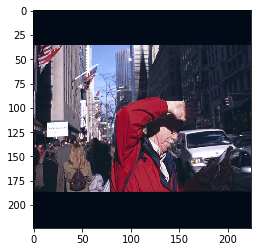

In [13]:
(x_img, x_seq), y = K.get_session().run(next_item)
plt.imshow(np.clip(x_img[0] + 127., 0, 255).astype(np.uint8)[...,::-1])

for i in range(16):
    print(x_seq[i], " -> ", np.argmax(y[i]))
    print(' '.join(tokenizer.sequences_to_texts([x_seq[i]])) + " -> " + tokenizer.sequences_to_texts([[np.argmax(y[i])]])[0])

## GLOVE word embeddings

Stanford are offering to download a pretrained word embedding model called GLOVE (Global Vectors for Word Representation): https://nlp.stanford.edu/projects/glove/

As you may remember word embeddings are a word2vec model that is essentially a way to turn words into numeric representation while encoding their semantics.

This will take a while... (130Mb download and unzip)

In [14]:
if not os.path.isfile('glove.6B.100d.txt'):
    GLOVE_URL = 'https://storage.googleapis.com/cse527-spring19/glove.6B.100d.txt.zip'
    zipf = zipfile.ZipFile(io.BytesIO(requests.get(GLOVE_URL).content))
    zipf.extractall('.')
    zipf.close()

In [15]:
embeddings_index = {}
with open(os.path.join('.', 'glove.6B.100d.txt')) as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:14, 27245.55it/s]

Found 400000 word vectors.


In [16]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS + 1, len(tokenizer.word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


## Fun with word embeddings

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)
pca.fit(embedding_matrix[:400]);

Let's see how word embeddings encode the "captial city" relationship. We pose nations w.r.t to their captial cities and see the translation is mostly similar between them.

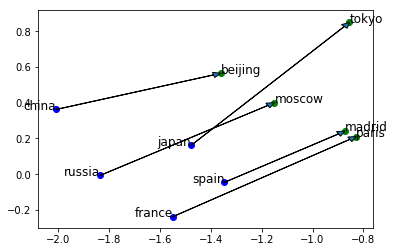

In [19]:
for k,v in [('russia','moscow'),('france','paris'),('spain','madrid'),('china','beijing'),('japan','tokyo')]:
    a_v = pca.transform([embeddings_index.get(k)])[0]
    b_v = pca.transform([embeddings_index.get(v)])[0]
    plt.scatter([a_v[0]], [a_v[1]], c='blue')
    plt.scatter([b_v[0]], [b_v[1]], c='green')
    plt.arrow(a_v[0], a_v[1], b_v[0]-a_v[0], b_v[1]-a_v[1], head_width=0.03, head_length=0.03, length_includes_head=True)
    plt.text(a_v[0], a_v[1], k, fontsize='large', horizontalalignment='right')
    plt.text(b_v[0], b_v[1], v, fontsize='large')    

You're welcome to add more nations and captials to see the relationships.

In [20]:
from sklearn.neighbors import NearestNeighbors

In [21]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(embedding_matrix)

We can also do some arithmetics, for example: `King - Man + Woman ~= Queen`.

Let's see if it works:

In [22]:
should_be_queen = embeddings_index.get('king') - embeddings_index.get('man') + embeddings_index.get('woman')

In [23]:
tokenizer.sequences_to_texts(nbrs.kneighbors([should_be_queen])[1])

['daughter mother father son lady']

We see "queen".

In [24]:
del nbrs, pca

## Image captioning model

In [11]:
train_ds, test_ds = make_dataset()

Instructions for updating:
Colocations handled automatically by placer.


Create a layer to convert from word index -> word embedding (length 100 vector)

In [17]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH-1,
                            trainable=False)

Load VGG pretrained model for visual features extraction

In [18]:
# TODO: vgg = VGG16(...) # make sure `include_top=False)
vgg = VGG16(include_top = False, weights='imagenet')

# TODO: set all layers' `trainable = False`
for l in vgg.layers: l.trainable = False

# TODO: pick the last layer as `vgg_out`
vgg_out = vgg.layers[-1].output

Build a captioning DNN model:

In [19]:
inputs2 = Input(shape=(MAX_SEQUENCE_LENGTH-1,))

# TODO: add embedding_layer(...)
# TODO: use e.g. `GlobalAveragePooling2D` over the output of the vgg
# TODO: use a Dense layer to get 256 outputs 
# TODO: use BatchNormalization() for regularization
# TODO: add `linear`, `sigmoid` [0,1] or `tanh` [-1,1] activations

x = embedding_layer(inputs2)

vgg_out_small = GlobalAveragePooling2D()(vgg_out)
vgg_out_small = Dense(256, activation='tanh')(vgg_out_small)
vgg_out_small = BatchNormalization()(vgg_out_small)

# TODO: now add a `CuDNNGRU` or `CuDNNLSTM`, and set the `initial_state=[vgg_out]`
# e.g. x = CuDNNGRU(256)(x, initial_state=[vgg_out_small])
x = CuDNNGRU(256)(x, initial_state=[vgg_out_small])

# TODO: use a couple of Dense layers and finally take a `softmax` activation to `num_words` (vocabulary size)
# This will ensure we're trying to predict the right word at that time step.
x = Dense(256)(x)
x = Dense(num_words, activation = 'softmax')(x)

outputs = x

model = Model(inputs=[vgg.input, inputs2], outputs=outputs)

## Train!

The loss is `categorical_crossentropy` because of a softmax activation, we're trying to predict a word out the vocabulary.

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
checkpoint = ModelCheckpoint('image_captioning.best_weights.hdf5', 
                             monitor='val_acc', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto')

In [22]:
model.fit(train_ds, 
          steps_per_epoch=35000//64,
          epochs=50,
          validation_data=test_ds,
          validation_steps=20,
          callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
546/546 [==============================] - 595s 1s/step - loss: 4.1918 - acc: 0.2484 - val_loss: 3.4580 - val_acc: 0.3289
Epoch 2/50
546/546 [==============================] - 540s 989ms/step - loss: 3.6189 - acc: 0.2939 - val_loss: 3.7122 - val_acc: 0.2805
Epoch 3/50
546/546 [==============================] - 542s 993ms/step - loss: 3.4358 - acc: 0.3093 - val_loss: 3.3151 - val_acc: 0.3320
Epoch 4/50
546/546 [==============================] - 542s 992ms/step - loss: 3.3864 - acc: 0.3108 - val_loss: 3.6044 - val_acc: 0.2898
Epoch 5/50
546/546 [==============================] - 539s 987ms/step - loss: 3.3333 - acc: 0.3167 - val_loss: 3.3667 - val_acc: 0.2859
Epoch 6/50
546/546 [==============================] - 539s 988ms/step - loss: 3.2405 - acc: 0.3197 - val_loss: 3.5136 - val_acc: 0.3016
Epoch 7/50
546/546 [==============================] - 541s 991ms/step - loss: 3.2356 - acc: 0.3156 - val_loss: 3.4488 - val_acc: 0.3070
Epo

In [23]:
model.load_weights('image_captioning.best_weights.hdf5')

### Testing the model

In [29]:
it_test = test_ds.make_one_shot_iterator()
next_test = it_test.get_next()

In [30]:
(test_im, test_seq), test_y = K.get_session().run(next_test)

Text(0.5, 1.0, '<pad> <pad> <pad> a boy in a red jacket pouring water on a man')

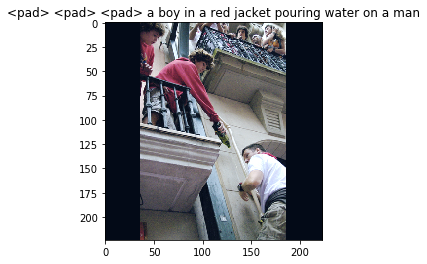

In [31]:
plt.imshow(np.uint8(np.clip(test_im[0] + 127., 0, 255))[...,::-1])
plt.title(tokenizer.sequences_to_texts([test_seq[0]])[0])

Use "feedback" from the last prediction to feed back into the model for another prediction.

In [32]:
seq = [tokenizer.word_index['<pad>']] * (MAX_SEQUENCE_LENGTH - 1)
for i in range(MAX_SEQUENCE_LENGTH - 1):
    y_pred = model.predict(([test_im[15]],[seq]))
    seq = seq[1:] + [np.argmax(y_pred)]

['a man in a red shirt and a <unk> <unk> <unk> <unk> <unk> <unk>']


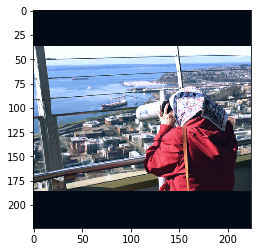

In [33]:
print(tokenizer.sequences_to_texts([seq]))
plt.imshow(np.uint8(np.clip(test_im[15] + 127., 0, 255))[...,::-1]);

## Variational Autoencoder

VAEs are a probabilistic approach to autoencoders, which allow us to learn a latent variable space that is sematically meaningful by being a proper probabilty function (instead of an arbitrary vector space).

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO}(\lambda) = \mathbb{E}_{q_\lambda(z|x)}\left[\log \frac{p(x, z)}{q_\lambda(z|x)}\right].$$

(note the joint probablity $p(x,z)$, which is imposed over *all of $x$* - all possible input images)

In the variational autoencoder model, no datapoint $x_i$ shares its latent $z$ with the latent variable of another datapoint $x_j$ (there are only local latent variables). 
So we can decompose the ELBO into a sum where each term depends on a single datapoint. 
This allows us to use stochastic gradient descent with respect to the parameters $\lambda$.

The ELBO for a single datapoint in the variational autoencoder is:

$$ELBO_i(\lambda) = \mathbb{E}_{q_\lambda(z\mid x_i)}[\log p(x_i\mid z)] - \mathfrak{D}_\text{KL}(q_\lambda(z\mid x_i) \mid\mid p(z))$$

The encoder distribution is $q(z|x)=\mathcal{N}(z|\mu(x),\Sigma(x))$ where $\Sigma=\text{diag}(\sigma_1,\ldots,\sigma_n)$, while the latent prior is given by $p(z)=\mathcal{N}(0,I)$. Both are multivariate Gaussians of dimension $n$, for which in general the KL divergence is:
$$
\mathfrak{D}_\text{KL}[p_1\mid\mid p_2] =
\frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - n + \text{tr} \{ \Sigma_2^{-1}\Sigma_1 \} + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]
$$
where $p_1 = \mathcal{N}(\mu_1,\Sigma_1)$ and $p_2 = \mathcal{N}(\mu_2,\Sigma_2)$.

In the VAE case, $p_1 = q(z|x)$ and $p_2=p(z)$, so $\mu_1=\mu$, $\Sigma_1 = \Sigma$, $\mu_2=\vec{0}$, $\Sigma_2=I$. Thus:
\begin{align}
\mathfrak{D}_\text{KL}[q(z|x)\mid\mid p(z)] 
&=
\frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - n + \text{tr} \{ \Sigma_2^{-1}\Sigma_1 \} + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]\\
&= \frac{1}{2}\left[\log\frac{|I|}{|\Sigma|} - n + \text{tr} \{ I^{-1}\Sigma \} + (\vec{0} - \mu)^T I^{-1}(\vec{0} - \mu)\right]\\
&= \frac{1}{2}\left[-\log{|\Sigma|} - n + \text{tr} \{ \Sigma \} + \mu^T \mu\right]\\
&= \frac{1}{2}\left[-\log\prod_i\sigma_i^2 - n + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]\\
&= \frac{1}{2}\left[-\sum_i\log\sigma_i^2 - n + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]\\
&= \frac{1}{2}\left[-\left(\sum_i\log\sigma_i^2 + 1\right) + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]\\
\end{align}

Get the grayscale faces DB

In [31]:
data = np.load(io.BytesIO(requests.get('https://storage.googleapis.com/cse527-spring19/faces_db.npz').content))
faces = data['faces']

In [32]:
latent_dim = 100
IMAGE_SIZE = 48

In [33]:
K.clear_session()

Build a convolutional VAE model

In [34]:
# encoder
encoder_input = Input(shape=(48, 48, 1))
# TODO: add a few Conv2D layers
x = Conv2D(16, (3,3), activation='relu', padding='same', strides=(2, 2))(encoder_input)
x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(2, 2))(x)

# TODO: Flatten()(x)...
x = Flatten()(x)

# TODO: use Dense to get two outputs: z_mean and z_log_var
z_mean = Dense(latent_dim, activation = 'linear')(x)
z_log_var = Dense(latent_dim, activation = 'linear')(x)

encoder_model = Model(encoder_input, [z_mean, z_log_var])

# generator
generator_input = Input(shape=(latent_dim,))

# TODO: use Dense to go to e.g. 6x6x32 units and the `Reshape` to a true (6, 6, 32) tensor
y = Dense(6*6*32, activation = 'linear')(generator_input)
y = Reshape((6, 6, 32))(y)

# TODO: use a few Conv2DTranspose to go from 6x6x32 to 48x48x1
# TODO: add a `sigmoid` activation (output [0,1] like our images)
y = Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2, 2))(y)
y = Conv2DTranspose(16, (3,3), activation='relu', padding='same', strides=(2, 2))(y)
y = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same', strides=(2, 2))(y)

generator_model = Model(generator_input, y)

In [35]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 32)     9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten (F

In [36]:
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1152)              116352    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 48, 48, 1)         145       
Total params: 130,369
Trainable params: 130,369
Non-trainable params: 0
_________________________________________________________________


In [37]:
# reparameterization trick: sample from ~ N(0,I) then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim)) # mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [38]:
# VAE model
z = Lambda(sampling, output_shape=(latent_dim,), name='z')(encoder_model.outputs)
vae = Model(encoder_model.inputs, generator_model(z), name='vae')

In [39]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 32)     9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten (F

### VAE Loss
This is where the ELBO loss comes into play.

Recall we derived: 
$$\mathcal{D}_\text{KL}[q(z|x)\mid\mid p(z)] = \frac{1}{2}\left[-\left(\sum_i\log\sigma_i^2 + 1\right) + \sum_i\sigma_i^2 + \sum_i\mu^2_i\right]$$

How about the log likelyhood? $\mathbb{E}_{q_\lambda(z\mid x_i)}[\log p(x_i\mid z)]$

Well the MSE is actually the maximum likelihood estimator (MLE) of the Gaussian log likelihood, so we can just use the MSE. https://www.jessicayung.com/mse-as-maximum-likelihood/

In [40]:
def vae_loss(x, x_vae):
    # use the MSE for reconstruction MLE
    reconstruction_loss = mse(K.flatten(x), K.flatten(x_vae)) * IMAGE_SIZE * IMAGE_SIZE

    # calculate the KLD loss, remember `z_log_var` is the log(variance), thus it needs an `K.exp(...)`
    # TODO: use K.square, K.exp to calculate the above D_KL
    kl_loss = -0.5 * K.sum((z_log_var + 1 - K.square(z_mean) - K.exp(z_log_var)), axis=-1)
    
    # VAE loss = mse_loss + kl_loss
    return K.mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)

### Train

In [41]:
dataset = tf.data.Dataset.from_tensor_slices(np.array(faces).astype(np.float32) / 255.0)
dataset = dataset.map(lambda x: tf.expand_dims(x,-1))
dataset = dataset.map(lambda x: (x, x))
train_dataset = dataset.take(4000).batch(32).repeat()
test_dataset = dataset.skip(4000).batch(32).repeat()

In [42]:
vae.fit(train_dataset,
       epochs=50,
       steps_per_epoch=4000//32,
       validation_data=test_dataset,
       validation_steps=7)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
125/125 [==============================] - 3s 25ms/step - loss: 150.7484 - val_loss: 122.7860
Epoch 2/50
125/125 [==============================] - 2s 12ms/step - loss: 117.3744 - val_loss: 112.9635
Epoch 3/50
125/125 [==============================] - 1s 11ms/step - loss: 110.8819 - val_loss: 109.2163
Epoch 4/50
125/125 [==============================] - 1s 11ms/step - loss: 106.7313 - val_loss: 106.0999
Epoch 5/50
125/125 [==============================] - 1s 11ms/step - loss: 103.3556 - val_loss: 102.4217
Epoch 6/50
125/125 [==============================] - 2s 13ms/step - loss: 99.9953 - val_loss: 99.4996
Epoch 7/50
125/125 [==============================] - 1s 11ms/step - loss: 97.7680 - val_loss: 97.1618
Epoch 8/50
125/125 [==============================] - 2s 12ms/step - loss: 96.2140 - val_loss: 95.6191
Epoch 9/50
125/125 [==============================] - 2s 13ms/step - loss: 94.7221 - val_loss: 93.6210
Epoch 10/50
125

### Test

In [43]:
it = train_dataset.make_one_shot_iterator()
x_,y_ = K.get_session().run(it.get_next())

In [44]:
zs = encoder_model.predict(x_)

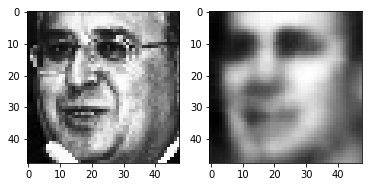

In [45]:
plt.subplot(122),plt.imshow(np.squeeze(generator_model.predict(np.expand_dims(zs[0][0],0))), cmap='gray')
plt.subplot(121),plt.imshow(np.squeeze(x_[0]),cmap='gray');

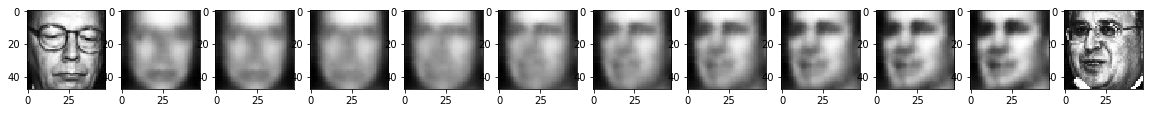

In [46]:
# morph one face to another over the latent space
plt.figure(figsize=(20,3))
plt.subplot(1,12,1), plt.imshow(np.squeeze(x_[1]), cmap='gray')
plt.subplot(1,12,12), plt.imshow(np.squeeze(x_[0]), cmap='gray')
for i, f in enumerate(np.linspace(0,1,10)):
    blend_z = np.expand_dims(zs[0][0] * f + zs[0][1] * (1.0 - f), 0)
    plt.subplot(1,12,i+2)
    plt.imshow(np.squeeze(generator_model.predict(blend_z)), cmap='gray')

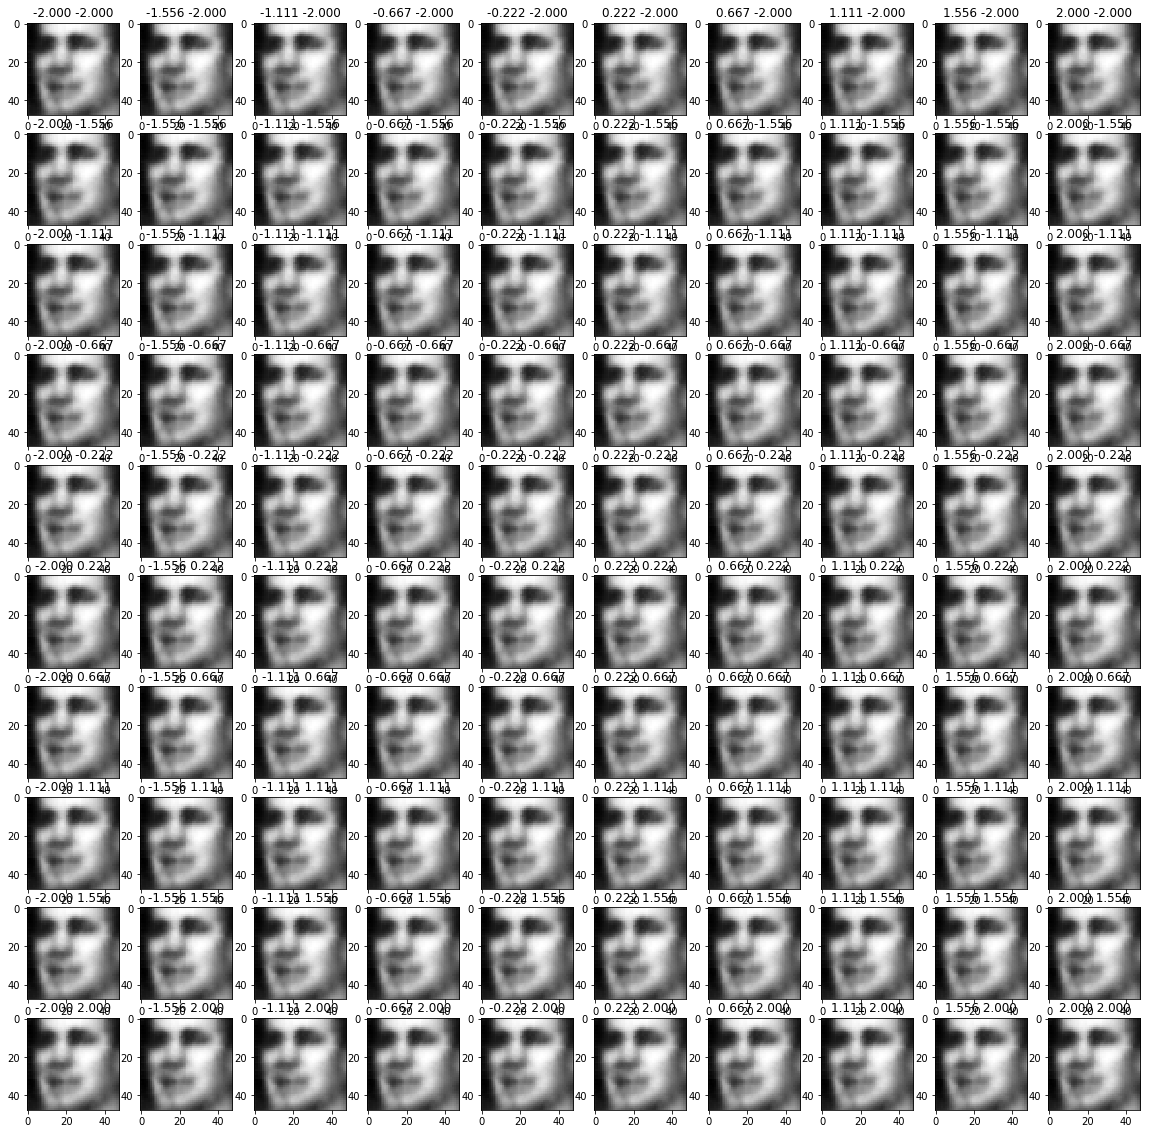

In [47]:
# change the 1st and 2nd variables in the latent space for a morph grid
grid = np.dstack(np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10)))

plt.figure(figsize=(20,20))
for i in range(10):
    for j in range(10):
        grid_z = zs[0][0].copy()
        grid_z[:2] += grid[i,j]
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(np.squeeze(generator_model.predict(np.expand_dims(grid_z,0))), cmap='gray')        
        plt.title("%.3f %.3f"%(grid[i,j][0], grid[i,j][1]))

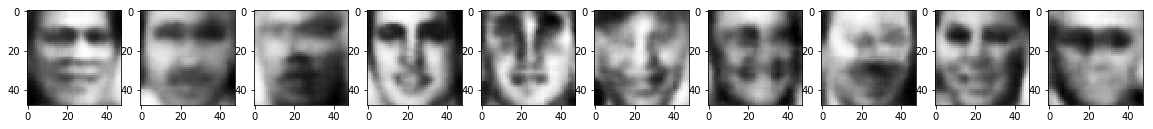

In [48]:
# some totally random faces
plt.figure(figsize=(20,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(np.squeeze(generator_model.predict(np.random.normal(0,1,(1,100)))), cmap='gray')

Some of them are nice, but some... pretty creepy.

## Generative Adversarial Network (GAN)

Adversarial networks are a useful way to make generative models. By posing the Generator model vs. a Discriminator that looks to classify real vs. fake generated images, overall the generator becomes very good at faking images.

Here we build a deep convolutinal GAN (DCGAN), a simple yet effective GAN architecture that serves as an excellent tutorial.

In [109]:
K.clear_session()

In [110]:
latent_dim = 100

Build a deep convoltional generator that takes random noise in a small latent space and turns it into an image.

In [111]:
dcgan_gen_input = Input(shape=(latent_dim,))
# TODO: Use `Dense`, `Conv2DTranspose`, `BatchNormalization`, `ReLU` or `LeakyReLU` - to build the DC generator
# TODO: end with an output that's shaped (48, 48, 1)

x = Dense(6*6*128, activation = 'linear', kernel_initializer='random_normal')(dcgan_gen_input)
x = Reshape((6, 6, 128))(x)
x = Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=(2, 2), kernel_initializer='random_normal')(x)
x = Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=(2, 2), kernel_initializer='random_normal')(x)
x = Conv2DTranspose(1, (3,3), activation='relu', padding='same', strides=(2, 2), kernel_initializer='random_normal')(x)

dcgan_gen_model = Model(dcgan_gen_input, x)

Build a deep convoluional discriminator that takes in an image and predicts whether it's real or fake (binary).

In [112]:
dcgan_des_input = Input(shape=(48,48,1))
# TODO: Use `Conv2D`, `ReLU` or `LeakyReLU`, `Dropout`, `Flatten` and `Dense` to build the DC discriminator
# TODO: end with a Dense(1) layer with activation='tanh'

x = Conv2D(32, (5, 5), padding='same', activation='relu', kernel_initializer='random_normal')(dcgan_des_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='random_normal')(x)
x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='random_normal')(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation='tanh', kernel_initializer='random_normal')(x)
x = Dense(1, activation='tanh', kernel_initializer='random_normal')(x)


dcgan_dis_model = Model(dcgan_des_input, x)

In [113]:
# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

The discriminator uses binary ('fake'/'real') crossentropy loss

In [114]:
dcgan_dis_model.trainable = True
dcgan_dis_model.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1), loss='binary_crossentropy')

Make a "combined" model that runs the discriminator on the generator output.

In [115]:
# we only want to be able to train the generator with the combined model, not the discriminator
dcgan_dis_model.trainable = False
combined = Model(dcgan_gen_input, dcgan_dis_model(dcgan_gen_model.output))

combined.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1), loss='binary_crossentropy')

## Train
The model is not yet trained, so it's generating random noise

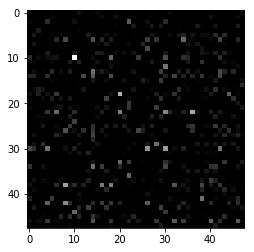

In [116]:
generated_image = dcgan_gen_model.predict(np.random.uniform(-1,1,(1, latent_dim)))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The untrained discriminator is also unable to make a proper prediction.

In [117]:
dcgan_dis_model.predict(generated_image)

array([[-0.01886361]], dtype=float32)

#### Training loop

In [118]:
BATCH_SIZE = 32
NUM_BATCHES = len(faces) // BATCH_SIZE

epochs = 100

# use one-sided soft real/fake labels
# Salimans et al., 2016
# https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
soft_zero, soft_one = 0.1, 0.95

In [119]:
# load and batch data
dataset = tf.data.Dataset.from_tensor_slices(np.array(faces).astype(np.float32) / 128.0 - 1.0)
dataset = dataset.map(lambda x: tf.expand_dims(x,-1))
dataset = dataset.batch(BATCH_SIZE).repeat()

In [120]:
it = dataset.make_one_shot_iterator()
next_batch = it.get_next()

Train!

In [121]:
from IPython.display import clear_output

Disc loss 0.90645826  Gen loss 0.8188429


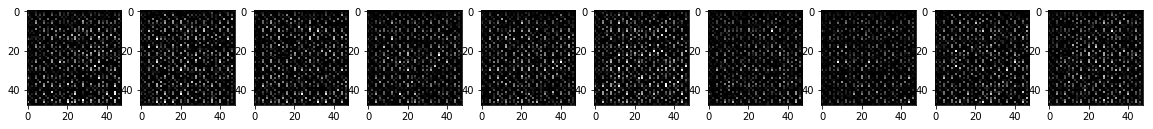



Epoch 51/100:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 51/100:   1%|          | 1/131 [00:00<00:15,  8.41it/s]

Epoch 51/100:   2%|▏         | 2/131 [00:00<00:15,  8.32it/s]

Epoch 51/100:   2%|▏         | 3/131 [00:00<00:15,  8.25it/s]

Epoch 51/100:   3%|▎         | 4/131 [00:00<00:15,  8.21it/s]

Epoch 51/100:   4%|▍         | 5/131 [00:00<00:15,  8.16it/s]

Epoch 51/100:   5%|▍         | 6/131 [00:00<00:15,  8.12it/s]

Epoch 51/100:   5%|▌         | 7/131 [00:00<00:15,  8.10it/s]

Epoch 51/100:   6%|▌         | 8/131 [00:00<00:15,  8.15it/s]

Epoch 51/100:   7%|▋         | 9/131 [00:01<00:14,  8.13it/s]

Epoch 51/100:   8%|▊         | 10/131 [00:01<00:14,  8.16it/s]

Epoch 51/100:   8%|▊         | 11/131 [00:01<00:14,  8.14it/s]

Epoch 51/100:   9%|▉         | 12/131 [00:01<00:14,  8.12it/s]

Epoch 51/100:  10%|▉         | 13/131 [00:01<00:14,  8.07it/s]

Epoch 51/100:  11%|█         | 14/131 [00:01<00:14,  8.15it/s]

Epoch 51/100:  11%|█▏        | 15/131 [00:01<00:14,  8.1

In [ ]:
epoch_gen_loss = []
epoch_disc_loss = []
for epoch in range(1, epochs + 1):
    for index in tqdm(range(NUM_BATCHES), desc='Epoch %d/%d'%(epoch, epochs)):
        # get a batch of real images
        image_batch = K.get_session().run(next_batch)
        batch_len = image_batch.shape[0]

        # generate a batch of fake images
        generated_images = dcgan_gen_model.predict(np.random.uniform(-1, 1, (batch_len, latent_dim)))
        
        # create a batch with a mix of fake and real images
        x = np.vstack([image_batch, generated_images])
        
        # create a vector with "0"s and "1"s to match the real and fake images classification
        y = np.array([soft_one] * batch_len + [soft_zero] * batch_len)

        # train discriminator on this batch
        epoch_disc_loss.append(dcgan_dis_model.train_on_batch(x, y))

        # make new noise. 
        noise = np.random.uniform(-1, 1, (2 * batch_len, latent_dim))

        # For the generator, we want all the labels to say "not-fake", e.g. "1"
        trick = np.full(2 * batch_len, soft_one) # a vector of all "1"s

        epoch_gen_loss.append(combined.train_on_batch(noise, trick))
        
    # show progress in this epoch
    clear_output(wait=True)
    print("Disc loss", np.mean(epoch_disc_loss), " Gen loss", np.mean(epoch_gen_loss))

    # generate 10 images
    plt.figure(figsize=(20,3))
    generated_image = dcgan_gen_model.predict(np.random.uniform(-1,1,(10, latent_dim)))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(generated_image[i, :, :, 0], cmap='gray')    
    plt.show()

The horror! Still, some generated faces look reasonable...

There are many **(many many!)** other types of GANs with different purposes and tricks: https://github.com/hindupuravinash/the-gan-zoo

Training GANs is a topic of heated debate! https://arxiv.org/pdf/1801.04406 

With so many suggested metrics and settings, there still isn't a single proven way to train GANs efficiently. There are however a lot of good tips: https://github.com/soumith/ganhacks

That's a wrap!